In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as cmo

In [2]:
ds0 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_ho_5_dx_500_f_43N_ini.nc')
ds1 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_ho_5_dx_500_f_43N_grd.nc')
ds2 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_0_frc.nc')

In [3]:
zlevs=30 
theta_s=5.0
theta_b=0.4
hc=5.0
R0=1027.0 
T0=25.0 
S0=35.0 
TCOEF=1.7e-4 
SCOEF=7.6e-4
M20=1e-6 
M2_yo=50e3 
M2_r=5e3
N20=1e-4 
N2_zo=50.0
N2_r=50.0
balanced_run=True

def get_depths(h, hc, s, Cs, dim):
    """SEE Eq. (2) or (3) on https://www.myroms.org/wiki/Vertical_S-coordinate"""
    return (hc * s + h * Cs) / (hc + h) * h


def C(theta_s, theta_b, s):
    C = (1.0 - np.cosh(theta_s * s)) / (np.cosh(theta_s) - 1.0)
    if theta_b > 0.0:
        return (np.exp(theta_b * C) - 1.0) / (1.0 - np.exp(-theta_b))
    else:
        return -C

In [4]:
'''
Create an initialization file.

Horizontal stratification is controlled by salinity (only)
Vertical stratification is controlled by temperature (only)

Stratification properties are conservative through
a linear equation of state:

   R0 == 1027.0d0                   ! kg/m3
   T0 == 25.0d0                      ! Celsius
   S0 == 35.0d0                     ! PSU
TCOEF == 1.7d-4                     ! 1/Celsius
SCOEF == 7.6d-4                     ! 1/PSU
'''
grd_path = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_ho_5_dx_500_f_43N_grd.nc'
grd = xr.open_dataset(grd_path)
g = 9.81
dy = 1 / grd.pn
s_w = xr.DataArray(np.linspace(-1., 0., zlevs + 1), dims=['s_w'])
s_rho = np.linspace(-1., 0., zlevs + 1)
s_rho = s_rho[:-1] + np.diff(s_rho) / 2
s_rho = xr.DataArray(s_rho, dims=['s_rho'])
Cs_r = C(theta_s, theta_b, s_rho)
Cs_w = C(theta_s, theta_b, s_w)

M2 = M20 * np.exp((M2_yo - grd.y_rho) / M2_r)
M2 = M2.where(grd.y_rho > M2_yo, M20)
salt = (M2 * dy / g / SCOEF).cumsum(axis=0)
salt -= salt[-1] - S0
salt = salt.expand_dims('s_rho') * np.ones((zlevs, 1, 1), 'd')
salt.coords['s_rho'] = s_rho
# (h, hc, s, Cs)
z = get_depths(grd.h, hc, s_rho, Cs_r, 's_rho')
Hz = get_depths(grd.h, hc, s_w, Cs_w, 's_w').diff('s_w').rename({'s_w': 's_rho'})
Hz.coords['s_rho'] = s_rho
N2 = N20 * np.exp(-(N2_zo - z) / N2_r)
N2 = N2.where(z > N2_zo, N20)

temp = xr.zeros_like(salt)
for n in range(zlevs):
    temp[n] = T0 - np.trapz(N2[n:] / (g * TCOEF), x=z[n:], axis=0)

#########################################
# Create dataset

ds = xr.Dataset({'temp': temp, 'salt': salt,
                 's_rho': s_rho, 'xi_rho': grd.xi_rho, 'eta_rho': grd.eta_rho})

if balanced_run:
    rhs = Hz * M2 / grd.f
    u_z = 0.5 * (rhs[:, :, 1:] + rhs[:, :, :-1])
    u = np.cumsum(u_z, axis=0)
    ubottom = np.zeros((1, u.shape[1], u.shape[2]))
    u = np.concatenate((ubottom, u))
    u = 0.5 * (u[1:] + u[:-1])
else:
    u = 0.

ds['ocean_time'] = xr.DataArray([0.0], dims=['ocean_time'])
ds['ocean_time'].attrs['units'] = 'days'

ds['u'] = xr.DataArray(u[np.newaxis, :, :, :],
                       dims=['ocean_time', 's_rho', 'eta_u', 'xi_u'],
                       attrs={'units': 'm s-1'})
ds['v'] = xr.DataArray(np.zeros((1, int(zlevs), grd.dims['eta_v'], grd.dims['xi_v'])),
                       dims=['ocean_time', 's_rho', 'eta_v', 'xi_v'],
                       attrs={'units': 'm s-1'})
ds['zeta'] = xr.DataArray(np.zeros((1, grd.dims['eta_rho'], grd.dims['xi_rho'])),
                          dims=['ocean_time', 'eta_rho', 'xi_rho'],
                          attrs={'units': 'm'})
ds['ubar'] = xr.DataArray(np.zeros((1, grd.dims['eta_u'], grd.dims['xi_u'])),
                          dims=['ocean_time', 'eta_u', 'xi_u'],
                          attrs={'units': 'm s-1'})
ds['vbar'] = xr.DataArray(np.zeros((1, grd.dims['eta_v'], grd.dims['xi_v'])),
                          dims=['ocean_time', 'eta_v', 'xi_v'],
                          attrs={'units': 'm s-1'})

# Examine parameter space 

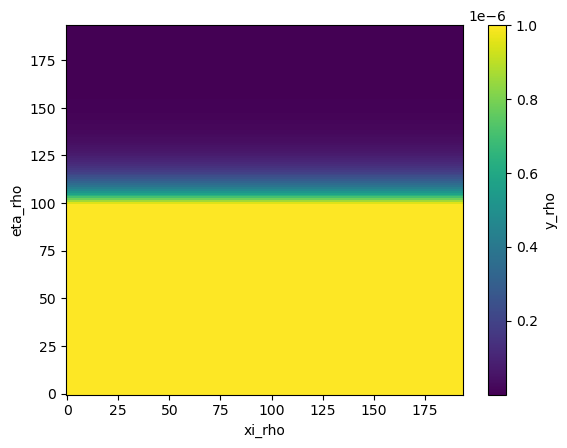

In [5]:
M2.plot()

In [8]:
N2[-1].values

array([[0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       ...,
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001]])

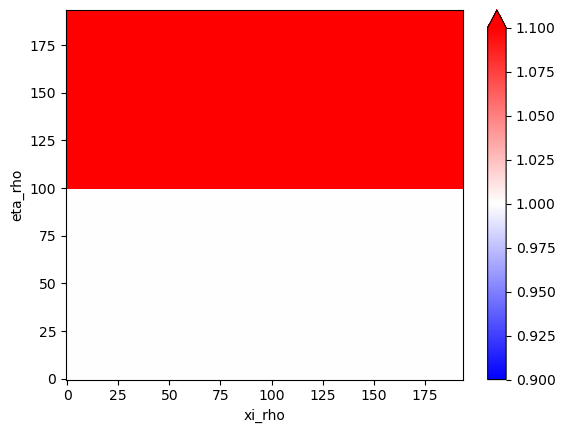

In [12]:
#Calculate Ri 
f = 1e-4
M = np.sqrt(M2)
Ri = N2*f**2*(M**-4)
Ri[-1].plot(vmax = 1, cmap = plt.get_cmap('bwr'))

In [14]:
ds.salt

<xarray.DataArray 'salt' (s_rho: 30, eta_rho: 194, xi_rho: 194)>
array([[[27.69039328, 27.69039328, 27.69039328, ..., 27.69039328,
         27.69039328, 27.69039328],
        [27.75745697, 27.75745697, 27.75745697, ..., 27.75745697,
         27.75745697, 27.75745697],
        [27.82452065, 27.82452065, 27.82452065, ..., 27.82452065,
         27.82452065, 27.82452065],
        ...,
        [34.99998772, 34.99998772, 34.99998772, ..., 34.99998772,
         34.99998772, 34.99998772],
        [34.99999417, 34.99999417, 34.99999417, ..., 34.99999417,
         34.99999417, 34.99999417],
        [35.        , 35.        , 35.        , ..., 35.        ,
         35.        , 35.        ]],

       [[27.69039328, 27.69039328, 27.69039328, ..., 27.69039328,
         27.69039328, 27.69039328],
        [27.75745697, 27.75745697, 27.75745697, ..., 27.75745697,
         27.75745697, 27.75745697],
        [27.82452065, 27.82452065, 27.82452065, ..., 27.82452065,
         27.82452065, 27.82452065],
...
        [34.99998772, 34.99998772, 34.99998772, ..., 34.99998772,
         34.99998772, 34.99998772],
        [34.99999417, 34.99999417, 34.99999417, ..., 34.99999417,
         34.99999417, 34.99999417],
        [35.        , 35.        , 35.        , ..., 35.        ,
         35.        , 35.        ]],

       [[27.69039328, 27.69039328, 27.69039328, ..., 27.69039328,
         27.69039328, 27.69039328],
        [27.75745697, 27.75745697, 27.75745697, ..., 27.75745697,
         27.75745697, 27.75745697],
        [27.82452065, 27.82452065, 27.82452065, ..., 27.82452065,
         27.82452065, 27.82452065],
        ...,
        [34.99998772, 34.99998772, 34.99998772, ..., 34.99998772,
         34.99998772, 34.99998772],
        [34.99999417, 34.99999417, 34.99999417, ..., 34.99999417,
         34.99999417, 34.99999417],
        [35.        , 35.        , 35.        , ..., 35.        ,
         35.        , 35.        ]]])
Coordinates:
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 7 ... 186 187 188 189 190 191 192 193
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 186 187 188 189 190 191 192 193
  * s_rho    (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.08333 -0.05 -0.01667

In [18]:
import xroms
path = '/d1/shared/shelfstrat_wind/43N/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_his.nc' #History file
ds1 = xroms.open_netcdf(path)
ds1, grid = xroms.roms_dataset(ds1)
ds1.salt[0].values

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


array([[[27.757458, 27.757458, 27.757458, ..., 27.757458, 27.757458,
         27.757458],
        [27.757458, 27.757458, 27.757458, ..., 27.757458, 27.757458,
         27.757458],
        [27.82452 , 27.82452 , 27.82452 , ..., 27.82452 , 27.82452 ,
         27.82452 ],
        ...,
        [34.99999 , 34.99999 , 34.99999 , ..., 34.99999 , 34.99999 ,
         34.99999 ],
        [34.999992, 34.999992, 34.999992, ..., 34.999992, 34.999992,
         34.999992],
        [34.999992, 34.999992, 34.999992, ..., 34.999992, 34.999992,
         34.999992]],

       [[27.757458, 27.757458, 27.757458, ..., 27.757458, 27.757458,
         27.757458],
        [27.757458, 27.757458, 27.757458, ..., 27.757458, 27.757458,
         27.757458],
        [27.82452 , 27.82452 , 27.82452 , ..., 27.82452 , 27.82452 ,
         27.82452 ],
        ...,
        [34.99999 , 34.99999 , 34.99999 , ..., 34.99999 , 34.99999 ,
         34.99999 ],
        [34.999992, 34.999992, 34.999992, ..., 34.999992, 34.999992,
   

In [ ]:
dsf = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_uwind_0_windtype_2_dx_500_frc.nc')
dsf1 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_uwind_0_windtype_4_dx_500_frc.nc')
dsf.sustr.plot()
dsf1.sustr.plot()

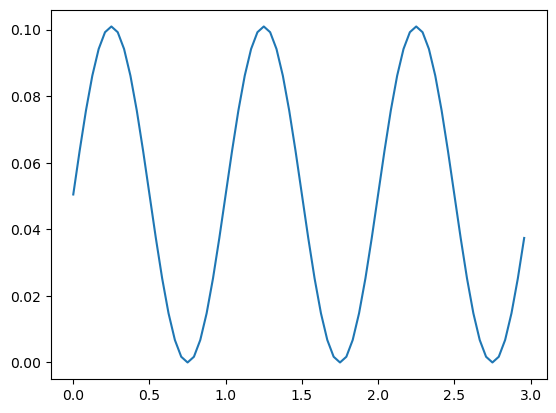

In [19]:
def get_diurnal_wind(uwind,vwind,Cd,ndays,dtw,Tramp,Tflat):
    '''
Calculates downwelling-favorable winds that oscillate diurnally.
    '''    
    sustr0 = Cd * np.sqrt(uwind**2 + vwind**2) * uwind
    svstr0 = Cd * np.sqrt(uwind**2 + vwind**2) * vwind
    t = xr.DataArray(np.arange(0, ndays+dtw, dtw), dims=['sms_time'])
    ramp = np.sin(t * 2.0 * np.pi)
    nt = int(Tflat / dtw)
    sustr1 = xr.DataArray((sustr0 * ramp), dims=['sms_time'])
    svstr1 = xr.DataArray((svstr0 * ramp), dims=['sms_time'])
    
    sustr = sustr1-sustr1.min().values
    svstr = svstr1-svstr1.min().values
    return sustr,svstr

uwind=5.8
vwind=0
Cd=1.5e-3
ndays=10
dtw=1/24
Tramp=1.0
Tflat=1

timevec = np.arange(0,len(sustr))/24
sustr,svstr = get_diurnal_wind(uwind,vwind,Cd,ndays,dtw,Tramp,Tflat)
plt.plot(timevec[:72],sustr[:72])

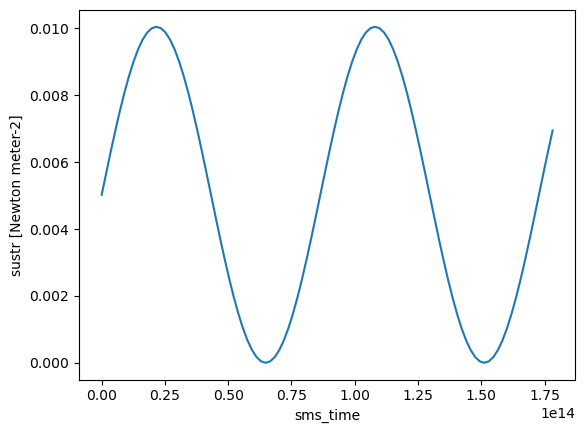

In [7]:
dsf.sustr[:100].plot()

In [2]:
dsi = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_ho_5_dx_500_ini.nc')
# dsg = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_ho_5_dx_500_grd.nc')
dsf = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_uwind_5_windtype_2_dx_500_frc.nc')

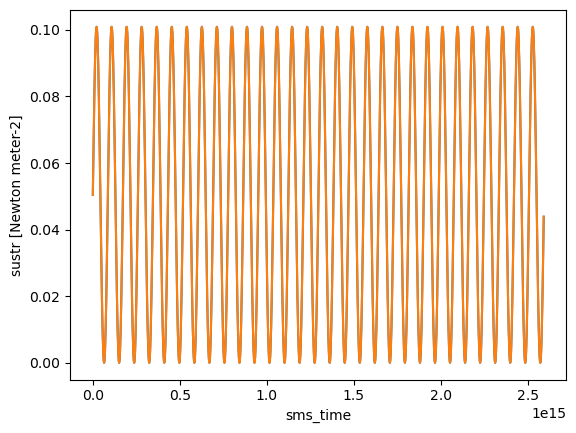

In [2]:
dsf = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_uwind_5_windtype_2_dx_500_frc.nc')
dsf1 = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_uwind_5_windtype_4_dx_500_frc.nc')
dsf.sustr.plot()
dsf1.sustr.plot()

In [19]:
ndays = 11
dtw = 1/48
np.arange(0, ndays+dtw, dtw)[:-1]

array([ 0.        ,  0.02083333,  0.04166667,  0.0625    ,  0.08333333,
        0.10416667,  0.125     ,  0.14583333,  0.16666667,  0.1875    ,
        0.20833333,  0.22916667,  0.25      ,  0.27083333,  0.29166667,
        0.3125    ,  0.33333333,  0.35416667,  0.375     ,  0.39583333,
        0.41666667,  0.4375    ,  0.45833333,  0.47916667,  0.5       ,
        0.52083333,  0.54166667,  0.5625    ,  0.58333333,  0.60416667,
        0.625     ,  0.64583333,  0.66666667,  0.6875    ,  0.70833333,
        0.72916667,  0.75      ,  0.77083333,  0.79166667,  0.8125    ,
        0.83333333,  0.85416667,  0.875     ,  0.89583333,  0.91666667,
        0.9375    ,  0.95833333,  0.97916667,  1.        ,  1.02083333,
        1.04166667,  1.0625    ,  1.08333333,  1.10416667,  1.125     ,
        1.14583333,  1.16666667,  1.1875    ,  1.20833333,  1.22916667,
        1.25      ,  1.27083333,  1.29166667,  1.3125    ,  1.33333333,
        1.35416667,  1.375     ,  1.39583333,  1.41666667,  1.43

In [3]:
dsg

<xarray.Dataset>
Dimensions:    (eta_vert: 195, xi_vert: 195, eta_rho: 194, xi_rho: 194, eta_psi: 193, xi_psi: 193, eta_u: 194, xi_u: 193, eta_v: 193, xi_v: 194)
Dimensions without coordinates: eta_vert, xi_vert, eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/18)
    x_vert     (eta_vert, xi_vert) float64 ...
    y_vert     (eta_vert, xi_vert) float64 ...
    x_rho      (eta_rho, xi_rho) float64 ...
    y_rho      (eta_rho, xi_rho) float64 ...
    x_psi      (eta_psi, xi_psi) float64 ...
    y_psi      (eta_psi, xi_psi) float64 ...
    ...         ...
    xl         int64 ...
    el         int64 ...
    spherical  bool ...
    f          (eta_rho, xi_rho) float64 ...
    angle      (eta_rho, xi_rho) float64 ...
    h          (eta_rho, xi_rho) float64 ...

In [4]:
dsi

<xarray.Dataset>
Dimensions:     (ocean_time: 1, eta_rho: 194, xi_rho: 194, s_rho: 30, eta_u: 194, xi_u: 193, eta_v: 193, xi_v: 194)
Coordinates:
  * ocean_time  (ocean_time) float64 0.0
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 187 188 189 190 191 192 193
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 187 188 189 190 191 192 193
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
Dimensions without coordinates: eta_u, xi_u, eta_v, xi_v
Data variables:
    temp        (s_rho, eta_rho, xi_rho) float64 ...
    salt        (s_rho, eta_rho, xi_rho) float64 ...
    u           (ocean_time, s_rho, eta_u, xi_u) float64 ...
    v           (ocean_time, s_rho, eta_v, xi_v) float64 ...
    zeta        (ocean_time, eta_rho, xi_rho) float64 ...
    ubar        (ocean_time, eta_u, xi_u) float64 ...
    vbar        (ocean_time, eta_v, xi_v) float64 ...
Attributes:
    type:         ROMS FRC file
    Description:  Initial conditions for ideal shelf
    Author:       Dylan Schlichting
    Created:      2023-01-23T17:21:59.784002

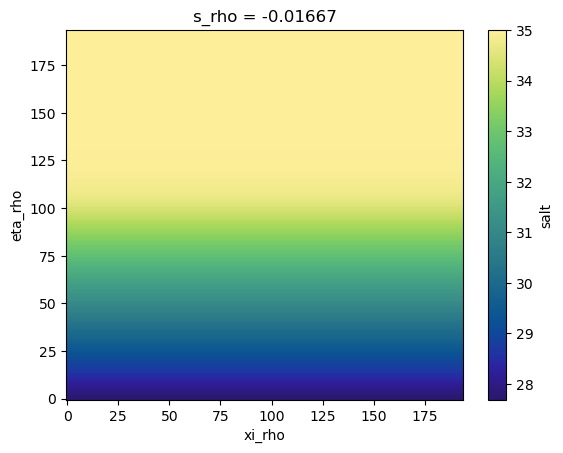

In [5]:
dsi.salt[-1,:,:].plot(cmap = cmo.haline, )

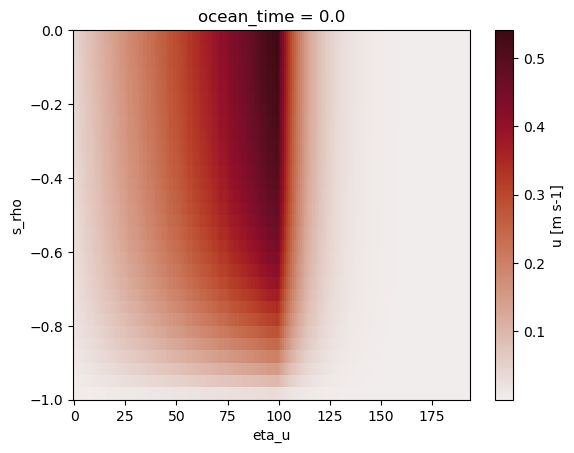

In [6]:
dsi.u[0,:,:,50].plot(cmap = cmo.amp, )

In [7]:
dsi.salt[-1].values

array([[27.69039328, 27.69039328, 27.69039328, ..., 27.69039328,
        27.69039328, 27.69039328],
       [27.75745697, 27.75745697, 27.75745697, ..., 27.75745697,
        27.75745697, 27.75745697],
       [27.82452065, 27.82452065, 27.82452065, ..., 27.82452065,
        27.82452065, 27.82452065],
       ...,
       [34.99998772, 34.99998772, 34.99998772, ..., 34.99998772,
        34.99998772, 34.99998772],
       [34.99999417, 34.99999417, 34.99999417, ..., 34.99999417,
        34.99999417, 34.99999417],
       [35.        , 35.        , 35.        , ..., 35.        ,
        35.        , 35.        ]])

In [8]:
# Calculate the model timestep $dt$ based on the CFL criteria. 

In [9]:
u = 0.5
dx = 500


In [10]:
bbbbbb

NameError: name 'bbbbbb' is not defined

In [11]:
ds = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_ho_5_dx_500_avg.nc')
ds

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:         (tracer: 5, s_rho: 30, s_w: 31, Nuser: 25, eta_rho: 194, xi_rho: 298, eta_u: 194, xi_u: 297, eta_v: 193, xi_v: 298, eta_psi: 193, xi_psi: 297, ocean_time: 39)
Coordinates:
  * s_rho           (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w             (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    x_rho           (eta_rho, xi_rho) float64 ...
    y_rho           (eta_rho, xi_rho) float64 ...
    x_u             (eta_u, xi_u) float64 ...
    y_u             (eta_u, xi_u) float64 ...
    x_v             (eta_v, xi_v) float64 ...
    y_v             (eta_v, xi_v) float64 ...
  * ocean_time      (ocean_time) object 0001-01-05 00:30:00 ... 0001-01-06 14...
Dimensions without coordinates: tracer, Nuser, eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/91)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          object ...
    nHIS            int32 ...
    ...              ...
    salt            (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    dye_03          (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    Huon            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    Hvom            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    AKv             (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKr             (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes: (12/28)
    file:              shelf_ho_5_dx_500_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             SHELFSTRAT
    var_info:          /scratch/user/dylan.schlichting/COAWST/ROMS/External/v...
    ...                ...
    compiler_command:  /sw/eb/sw/impi/2019.9.304-iccifort-2020.4.304/intel64/...
    compiler_flags:    -fp-model precise -ip -O3 -traceback
    tiling:            016x008
    history:           ROMS/TOMS, Version 3.9, Wednesday - January 11, 2023 -...
    ana_file:          /scratch/user/dylan.schlichting/COAWST/Projects/shelfs...
    CPP_options:       SHELFSTRAT, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_FS...

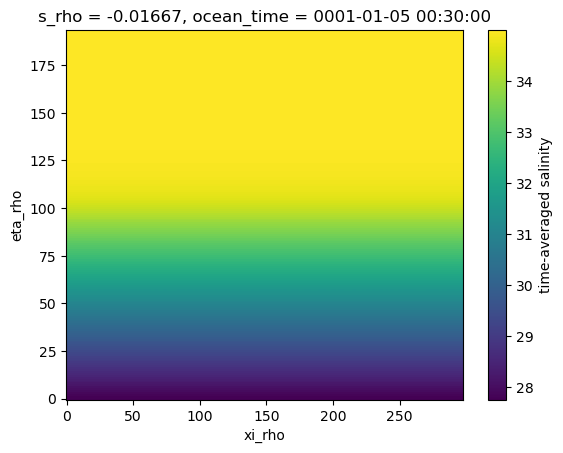

In [12]:
ds.salt[0,-1].plot()

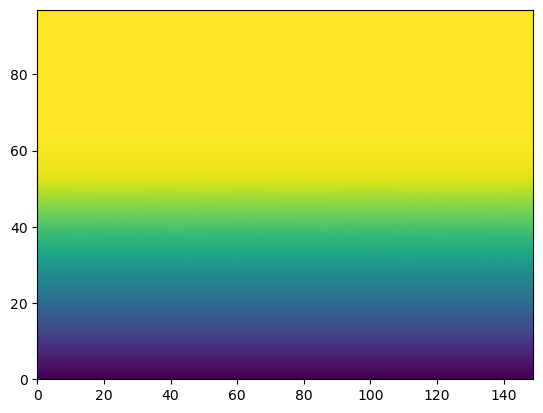

In [18]:
plt.pcolormesh(ds.x_rho/1000, ds.y_rho/1000,ds.salt[-1,-1],)


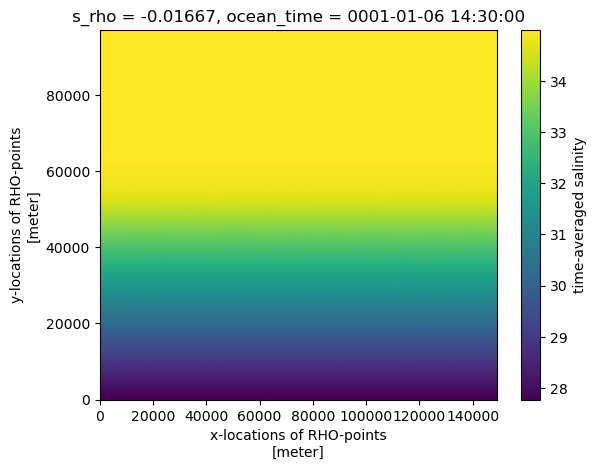

In [17]:
ds.salt[-1,-1].plot(x = 'x_rho', y = 'y_rho')

In [30]:
nt

24

In [4]:
uwind=1
vwind=0
Cd=1.5e-3
ndays=10
dtw=1/24
Tramp=1.0
Tflat=1

sustr0 = Cd * np.sqrt(uwind**2 + vwind**2) * uwind
svstr0 = Cd * np.sqrt(uwind**2 + vwind**2) * vwind
t = xr.DataArray(np.arange(0, ndays+dtw, dtw), dims=['sms_time'])
ramp = np.sin(t * 2.0 * np.pi)
nt = int(Tflat / dtw)
sustr = xr.DataArray(sustr0 * ramp, dims=['sms_time'])
svstr = xr.DataArray(svstr0 * ramp, dims=['sms_time'])
ds = xr.Dataset({'sms_time': t, 'sustr': sustr, 'svstr': svstr})

ds.attrs['Description'] = 'Forcing for ideal shelf'
ds.attrs['Author'] = 'Dylan Schlichting'
# ds.attrs['Created'] = datetime.now().isoformat()
ds.attrs['type'] = 'ROMS FRC file'
ds['sms_time'].attrs['units'] = 'days'
ds['sustr'].attrs['units'] = 'Newton meter-2'
ds['svstr'].attrs['units'] = 'Newton meter-2'

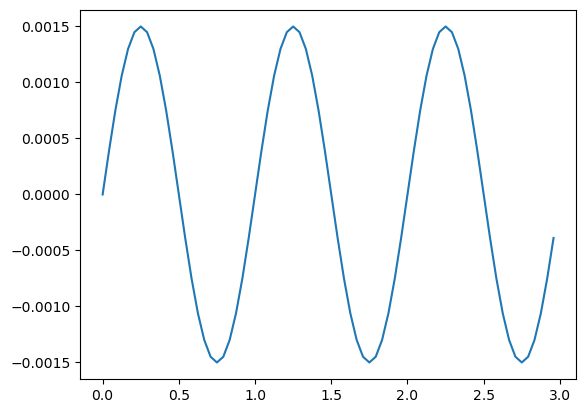

In [4]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
timevec = np.arange(0,len(sustr))/24

plt.plot(timevec[:72],sustr[:72])

# So this creates an idealized version of the land-sea breeze. Fucent wants us to include downwelling winds for diurnal and semidiurnal, so we should vertically shift this and decrease the amplitude

In [16]:
uwind=1
vwind=0
Cd=1.5e-3
ndays=10
dtw=1/24
Tramp=1.0
Tflat=1

sustr0 = Cd * np.sqrt(uwind**2 + vwind**2) * uwind
svstr0 = Cd * np.sqrt(uwind**2 + vwind**2) * vwind
t = xr.DataArray(np.arange(0, ndays+dtw, dtw), dims=['sms_time'])
ramp = np.sin(t * 2.0 * np.pi)
nt = int(Tflat / dtw)
sustr = xr.DataArray((sustr0 * ramp)+0.0135, dims=['sms_time'])
svstr = xr.DataArray((svstr0 * ramp)+0.0135, dims=['sms_time'])
ds = xr.Dataset({'sms_time': t, 'sustr': sustr, 'svstr': svstr})

ds.attrs['Description'] = 'Forcing for ideal shelf'
ds.attrs['Author'] = 'Dylan Schlichting'
# ds.attrs['Created'] = datetime.now().isoformat()
ds.attrs['type'] = 'ROMS FRC file'
ds['sms_time'].attrs['units'] = 'days'
ds['sustr'].attrs['units'] = 'Newton meter-2'
ds['svstr'].attrs['units'] = 'Newton meter-2'

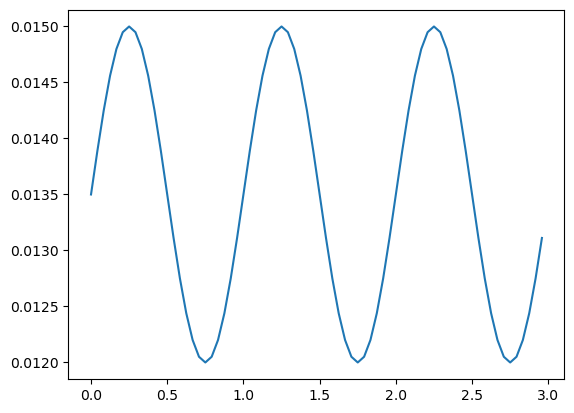

In [17]:
plt.plot(timevec[:72],sustr[:72])

In [18]:
sustr.min().values

array(0.012)

# So this brute force approach works, we can do better. Automate this with a function 

In [5]:
def get_diurnal_wind(uwind,vwind,Cd,ndays,dtw,Tramp,Tflat):
    '''
Calculates downwelling-favorable winds that oscillate diurnally.
    '''    
    sustr0 = Cd * np.sqrt(uwind**2 + vwind**2) * uwind
    svstr0 = Cd * np.sqrt(uwind**2 + vwind**2) * vwind
    t = xr.DataArray(np.arange(0, ndays+dtw, dtw), dims=['sms_time'])
    ramp = np.sin(t * 2.0 * np.pi)
    nt = int(Tflat / dtw)
    sustr1 = xr.DataArray((sustr0 * ramp), dims=['sms_time'])
    svstr1 = xr.DataArray((svstr0 * ramp), dims=['sms_time'])
    
    sustr = sustr1-sustr1.min().values
    svstr = svstr1-svstr1.min().values
    return sustr,svstr

uwind=1
vwind=0
Cd=1.5e-3
ndays=10
dtw=1/24
Tramp=1.0
Tflat=1

timevec = np.arange(0,len(sustr))/24
sustr,svstr = get_diurnal_wind(uwind,vwind,Cd,ndays,dtw,Tramp,Tflat)
plt.plot(timevec[:72],sustr[:72])

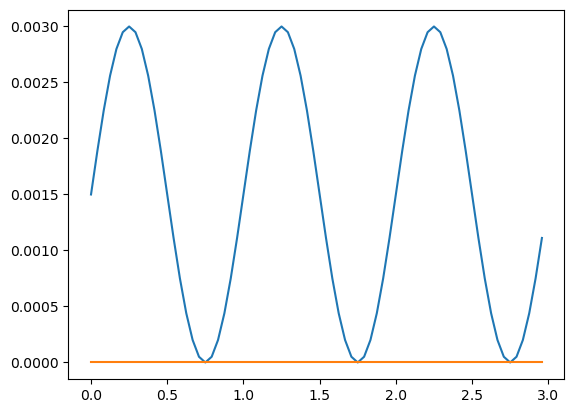

In [6]:
plt.plot(timevec[:72],sustr[:72])
plt.plot(timevec[:72],svstr[:72])

# Now change the inputs

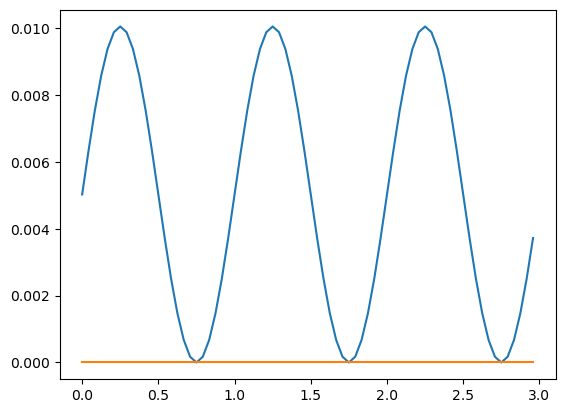

In [7]:
def get_diurnal_wind(uwind,vwind,Cd,ndays,dtw,Tramp,Tflat):
    '''
Calculates downwelling-favorable winds that oscillate diurnally.
    '''    
    sustr0 = Cd * np.sqrt(uwind**2 + vwind**2) * uwind
    svstr0 = Cd * np.sqrt(uwind**2 + vwind**2) * vwind
    t = xr.DataArray(np.arange(0, ndays+dtw, dtw), dims=['sms_time'])
    ramp = np.sin(t * 2.0 * np.pi)
    nt = int(Tflat / dtw)
    sustr1 = xr.DataArray((sustr0 * ramp), dims=['sms_time'])
    svstr1 = xr.DataArray((svstr0 * ramp), dims=['sms_time'])
    
    sustr = sustr1-sustr1.min().values
    svstr = svstr1-svstr1.min().values
    return sustr,svstr

uwind=1.83
vwind=0
Cd=1.5e-3
ndays=10
dtw=1/24
Tramp=1.0
Tflat=1

sustr,svstr = get_diurnal_wind(uwind,vwind,Cd,ndays,dtw,Tramp,Tflat)

plt.plot(timevec[:72],sustr[:72])
plt.plot(timevec[:72],svstr[:72])

In [36]:
sustr.max()

<xarray.DataArray ()>
array(0.0100467)

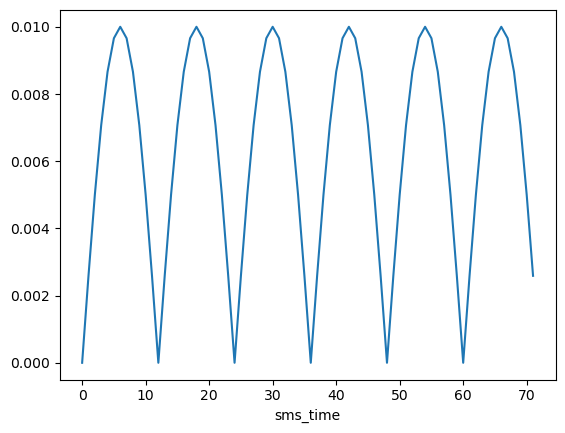

In [33]:
t = xr.DataArray(np.arange(0, ndays+dtw, dtw), dims=['sms_time'])
ramp = np.sin(t * 2.0 * np.pi)/100
np.abs(ramp[:72]).plot()

In [78]:
Cd * np.sqrt(uwind**2 + vwind**2) * uwind

0.0375

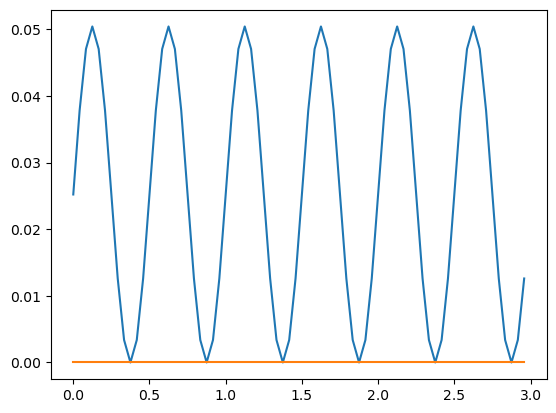

In [88]:
def get_semidiurnal_wind(uwind,vwind,Cd,ndays,dtw,Tramp,Tflat):
    '''
Calculates downwelling-favorable winds that oscillate semidiurnally.
    '''    
    sustr0 = Cd * np.sqrt(uwind**2 + vwind**2) * uwind
    svstr0 = Cd * np.sqrt(uwind**2 + vwind**2) * vwind
    t = xr.DataArray(np.arange(0, ndays+dtw, dtw), dims=['sms_time'])
    ramp = np.sin(t * 4.0 * np.pi)
    nt = int(Tflat / dtw)
    sustr1 = xr.DataArray((sustr0 * ramp), dims=['sms_time'])
    svstr1 = xr.DataArray((svstr0 * ramp), dims=['sms_time'])
    
    sustr = sustr1-sustr1.min().values
    svstr = svstr1-svstr1.min().values
    return sustr,svstr

uwind=4.1
vwind=0
Cd=1.5e-3
ndays=10
dtw=1/24
Tramp=1.0
Tflat=1

sustr,svstr = get_semidiurnal_wind(uwind,vwind,Cd,ndays,dtw,Tramp,Tflat)

plt.plot(timevec[:72],sustr[:72])
plt.plot(timevec[:72],svstr[:72])